In [15]:
from TicTacToe import Board, GameTools as gt
from Sample import random_samples

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.cluster import KMeans

## Sample data generation and Vectorization

In [16]:
# example of generating random samples using some of the parameters to adjust settings
# this sample set will contain 1000 matches
data = random_samples(n_samples=1000, save_file=False, rand_first_player=True, shuffled=True)

# this returns a pandas DataFrame
data.head()

,board,winner,1,2,3,4,5,6,7,8,9
0,"[[1, -1, 0], [0, 1, 1], [1, -1, 0]]",-1,6,-9,7,-5,3,-5,7,0,0
1,"[[0, -1, 1], [-1, -1, 0], [1, 1, -1]]",-1,7,-3,8,-7,5,0,0,0,0
2,"[[1, 1, 0], [-1, -1, -1], [0, -1, -1]]",-1,-5,3,-7,4,0,0,0,0,0
3,"[[0, 0, 1], [0, -1, -1], [-1, 1, -1]]",-1,-4,8,-3,5,-5,0,0,0,0
4,"[[0, 1, -1], [1, 1, 1], [0, -1, 0]]",1,5,-7,7,-3,4,-9,6,0,0


We have a lot of information compressed into a small table.

The first two columns are rarely used, but are kept for data validation. They are:
- "board": the game board in the form of a matrix. 'X' = 1, 'O' = 0, and an open space is represented with -1
- "winner": indicates if the match was completed, and if so, who won

The numbered columns are an ordered representation of every move made by each player during a match of TTT. This can then be vectorized to be easily fed into a learning algorithm! Let's look at how we do that.

In [17]:
# data is in the form of a pandas DataFrame. We can extract any columns we want to use for training data.
# we use the column keys (1, 2, 3, etc...) to extract them from the 'data' variable
train_X = data[[x for x in range(1, 10)]]

# looking at the extracted data
train_X.head()

,1,2,3,4,5,6,7,8,9
0,6,-9,7,-5,3,-5,7,0,0
1,7,-3,8,-7,5,0,0,0,0
2,-5,3,-7,4,0,0,0,0,0
3,-4,8,-3,5,-5,0,0,0,0
4,5,-7,7,-3,4,-9,6,0,0


In [18]:
# vectorizing the data can be done with the 'values' attribute. This returns a numpy nd.array
# we assign this to a new matrix, X
X = train_X.values

# looking at the resulting matrix
X

array([[ 6, -9,  7, ...,  7,  0,  0],
       [ 7, -3,  8, ...,  0,  0,  0],
       [-5,  3, -7, ...,  0,  0,  0],
       ...,
       [-5,  7, -7, ...,  0,  0,  0],
       [-7,  5, -9, ...,  0,  0,  0],
       [ 8, -9,  5, ...,  5,  0,  0]], dtype=int64)

The training data has now be vectorized. This allows for fitting and predicting to be computationally more efficient, and sets up an easy structure for getting predictions back from a model during implementation.

## K-Means Cluster - finding a K value

When clustering, it's difficult to know how many centroids to expect in the data. In order to effectively identify the proper amount, iterative testing is necessary. We will use a graphing library to observe the results.

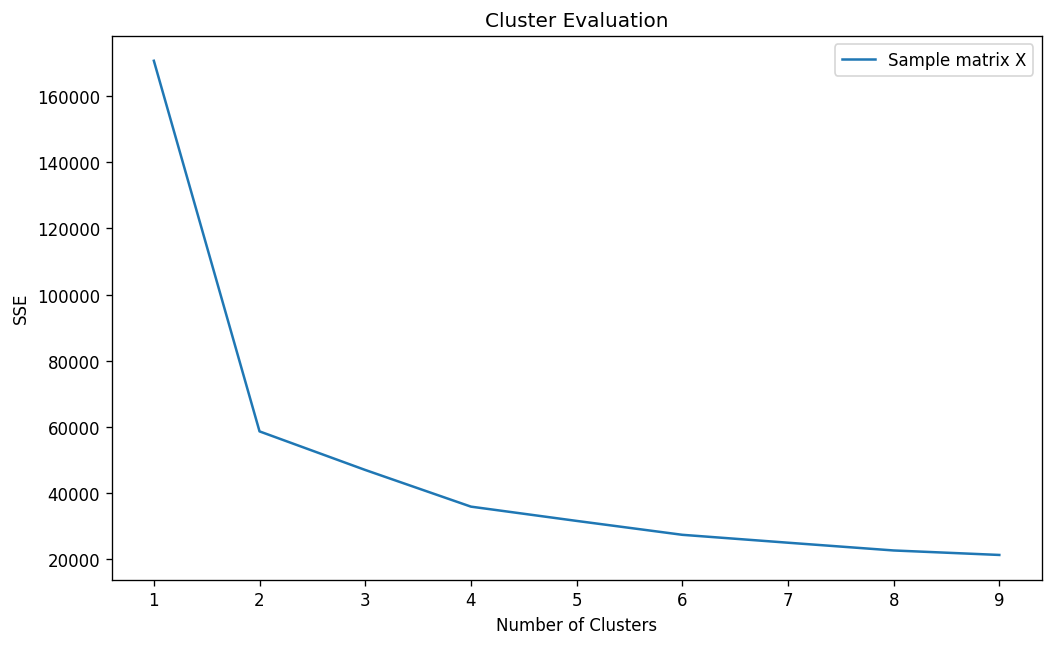

In [21]:
# initializing the plot and adjusting settings
plt.figure(figsize=(10, 6), dpi=120)

sse = dict()
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=2500).fit(X)
    sse[k] = kmeans.inertia_ # sum of squared euclidian distance from each point to its closest centroid
plt.plot(list(sse.keys()), list(sse.values()), label=f"Sample matrix X")

plt.title("Cluster Evaluation")
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.legend(loc="upper right")
plt.show()

There is an 'elbow' at k=2 clusters where the Sum of Squared Error (SSE) has a sharp change in direction. This indicates that the SSE is beinning to converge at k=2, which implies that our data is most likely split into 2 clusters.

In fact, if you continue to evaluate increasingly large datasets, the SSE will increase by an order of magnitude but the convergence still begins at k=2.

## K-Means Cluster - training a model

Since we now have evidence indicating that k=2, we can construct a model to classify games of Tic Tac Toe!

We will use SciKit-Learn to construct a simple model with the default parameters on a large dataset. Rather than loading in an already generated dataset, we will generate a new one.

In [40]:
# data set with 20000 samples
data_0 = random_samples(n_samples=10000)
train_Z = data_0[[x for x in range(1, 10)]]
Z = train_Z.values

# instantiating the KMeans model
model = KMeans(n_clusters=2)

# fitting the model to our Z data matrix
model.fit(Z)

# looking at our SSE
model.inertia_

587808.1551898001

It is worth noting the SSE scales linearly with the size of the training set.

We now have a trained model that can be used for classification. We still do not know what the classes are, however. This will need to be determined through either:
- classification of labeled data
- live testing

For now, we will just demonstrate how to use this model for classification.

In [43]:
# looking at the classifications of the first 100 elements of our smaller data matrix, X
model.predict(X)[:100]

array([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0])

The predictions from the model assign each sample to either class '1' or class '0'. 

It is assumed for now that each class indicates that a match is in-favor of player 'X' or player 'O'. This can be used for training a model like a decision tree for example!

Now that the model is trained and ready for live testing, we will save it into a binary file. This binary file will be loadable into any program to make predictions.

In [45]:
# using pickle library to write a new .sav file in binary in our specific directory
pickle.dump(model, open("model_binaries/example_kmeans.sav", "wb"))

This binary file can then be loaded in a similar way and then used for predictions.

In [47]:
km_model = pickle.load(open("model_binaries/example_kmeans.sav", "rb"))
km_model.predict(X)[:100]

array([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0])